***Note***
This jupyter notebook implements helmet use detection of bike riders in Copenhagen by using YOLOv3 and ResNet34 models. The training of these models are implemented in other files but not this.

In [1]:
from __future__ import division

import torch 
import torch.nn as nn
import torch.nn.functional as F 
from torch.autograd import Variable
import numpy as np
import random
import cv2 
import matplotlib.pyplot as plt
from util import count_parameters as count
from util import convert2cpu as cpu
from util import predict_transform
import pickle as pkl
import argparse
import os 
import os.path as osp
import pandas as pd
import itertools
import time
import math

In [2]:
import copy
from skimage import io, transform
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models
import torch.optim as optim
from torch.optim import lr_scheduler
from tqdm import tqdm
from utils_torch import *
import glob

***First*** We need to build YOLOv3 network by using the following codes. YOLOv3 is built on darknet framework, we can easily build such a network in the darknet class. The darknet model can be built from input configuration file and pretrained weights.

In [3]:
#darknet classes and parsing functions
class test_net(nn.Module):
    def __init__(self, num_layers, input_size):
        super(test_net, self).__init__()
        self.num_layers= num_layers
        self.linear_1 = nn.Linear(input_size, 5)
        self.middle = nn.ModuleList([nn.Linear(5,5) for x in range(num_layers)])
        self.output = nn.Linear(5,2)
    
    def forward(self, x):
        x = x.view(-1)
        fwd = nn.Sequential(self.linear_1, *self.middle, self.output)
        return fwd(x)
    
def get_test_input():
    img = cv2.imread("dog-cycle-car.png")
    img = cv2.resize(img, (416,416)) 
    img_ =  img[:,:,::-1].transpose((2,0,1))
    img_ = img_[np.newaxis,:,:,:]/255.0
    img_ = torch.from_numpy(img_).float()
    img_ = Variable(img_)
    return img_


def parse_cfg(cfgfile):
    """
    Takes a configuration file
    
    Returns a list of blocks. Each blocks describes a block in the neural
    network to be built. Block is represented as a dictionary in the list
    
    """
    file = open(cfgfile, 'r')
    lines = file.read().split('\n')     #store the lines in a list
    lines = [x for x in lines if len(x) > 0] #get read of the empty lines 
    lines = [x for x in lines if x[0] != '#']  
    lines = [x.rstrip().lstrip() for x in lines]

    
    block = {}
    blocks = []
    
    for line in lines:
        if line[0] == "[":               #This marks the start of a new block
            if len(block) != 0:
                blocks.append(block)
                block = {}
            block["type"] = line[1:-1].rstrip()
        else:
            key,value = line.split("=")
            block[key.rstrip()] = value.lstrip()
    blocks.append(block)

    return blocks
#    print('\n\n'.join([repr(x) for x in blocks]))


def create_modules(blocks):
    net_info = blocks[0]     #Captures the information about the input and pre-processing    
    
    module_list = nn.ModuleList()
    
    index = 0    #indexing blocks helps with implementing route  layers (skip connections)

    
    prev_filters = 3
    
    output_filters = []
    
    for x in blocks:
        module = nn.Sequential()
        
        if (x["type"] == "net"):
            continue
        
        #If it's a convolutional layer
        if (x["type"] == "convolutional"):
            #Get the info about the layer
            activation = x["activation"]
            try:
                batch_normalize = int(x["batch_normalize"])
                bias = False
            except:
                batch_normalize = 0
                bias = True
                
            filters= int(x["filters"])
            padding = int(x["pad"])
            kernel_size = int(x["size"])
            stride = int(x["stride"])
            
            if padding:
                pad = (kernel_size - 1) // 2
            else:
                pad = 0
                
            #Add the convolutional layer
            conv = nn.Conv2d(prev_filters, filters, kernel_size, stride, pad, bias = bias)
            module.add_module("conv_{0}".format(index), conv)
            
            #Add the Batch Norm Layer
            if batch_normalize:
                bn = nn.BatchNorm2d(filters)
                module.add_module("batch_norm_{0}".format(index), bn)
            
            #Check the activation. 
            #It is either Linear or a Leaky ReLU for YOLO
            if activation == "leaky":
                activn = nn.LeakyReLU(0.1, inplace = True)
                module.add_module("leaky_{0}".format(index), activn)
            
            
            
        #If it's an upsampling layer
        #We use Bilinear2dUpsampling
        
        elif (x["type"] == "upsample"):
            stride = int(x["stride"])
#            upsample = Upsample(stride)
            upsample = nn.Upsample(scale_factor = 2, mode = "nearest")
            module.add_module("upsample_{}".format(index), upsample)
        
        #If it is a route layer
        elif (x["type"] == "route"):
            x["layers"] = x["layers"].split(',')
            
            #Start  of a route
            start = int(x["layers"][0])
            
            #end, if there exists one.
            try:
                end = int(x["layers"][1])
            except:
                end = 0
                
            
            
            #Positive anotation
            if start > 0: 
                start = start - index
            
            if end > 0:
                end = end - index

            
            route = EmptyLayer()
            module.add_module("route_{0}".format(index), route)
            
            
            
            if end < 0:
                filters = output_filters[index + start] + output_filters[index + end]
            else:
                filters= output_filters[index + start]
                        
            
        
        #shortcut corresponds to skip connection
        elif x["type"] == "shortcut":
            from_ = int(x["from"])
            shortcut = EmptyLayer()
            module.add_module("shortcut_{}".format(index), shortcut)
            
            
        elif x["type"] == "maxpool":
            stride = int(x["stride"])
            size = int(x["size"])
            if stride != 1:
                maxpool = nn.MaxPool2d(size, stride)
            else:
                maxpool = MaxPoolStride1(size)
            
            module.add_module("maxpool_{}".format(index), maxpool)
        
        #Yolo is the detection layer
        elif x["type"] == "yolo":
            mask = x["mask"].split(",")
            mask = [int(x) for x in mask]
            
            
            anchors = x["anchors"].split(",")
            anchors = [int(a) for a in anchors]
            anchors = [(anchors[i], anchors[i+1]) for i in range(0, len(anchors),2)]
            anchors = [anchors[i] for i in mask]
            
            detection = DetectionLayer(anchors)
            module.add_module("Detection_{}".format(index), detection)
        
            
            
        else:
            print("Something I dunno")
            assert False


        module_list.append(module)
        prev_filters = filters
        output_filters.append(filters)
        index += 1
        
    
    return (net_info, module_list)


class MaxPoolStride1(nn.Module):
    def __init__(self, kernel_size):
        super(MaxPoolStride1, self).__init__()
        self.kernel_size = kernel_size
        self.pad = kernel_size - 1
    
    def forward(self, x):
        padded_x = F.pad(x, (0,self.pad,0,self.pad), mode="replicate")
        pooled_x = nn.MaxPool2d(self.kernel_size, self.pad)(padded_x)
        return pooled_x
    

class EmptyLayer(nn.Module):
    def __init__(self):
        super(EmptyLayer, self).__init__()
        

class DetectionLayer(nn.Module):
    def __init__(self, anchors):
        super(DetectionLayer, self).__init__()
        self.anchors = anchors
    
    def forward(self, x, inp_dim, num_classes, confidence):
        x = x.data
        global CUDA
        prediction = x
        prediction = predict_transform(prediction, inp_dim, self.anchors, num_classes, confidence, CUDA)
        return prediction
    

class Upsample(nn.Module):
    def __init__(self, stride=2):
        super(Upsample, self).__init__()
        self.stride = stride
        
    def forward(self, x):
        stride = self.stride
        assert(x.data.dim() == 4)
        B = x.data.size(0)
        C = x.data.size(1)
        H = x.data.size(2)
        W = x.data.size(3)
        ws = stride
        hs = stride
        x = x.view(B, C, H, 1, W, 1).expand(B, C, H, stride, W, stride).contiguous().view(B, C, H*stride, W*stride)
        return x
#       
        
class ReOrgLayer(nn.Module):
    def __init__(self, stride = 2):
        super(ReOrgLayer, self).__init__()
        self.stride= stride
        
    def forward(self,x):
        assert(x.data.dim() == 4)
        B,C,H,W = x.data.shape
        hs = self.stride
        ws = self.stride
        assert(H % hs == 0),  "The stride " + str(self.stride) + " is not a proper divisor of height " + str(H)
        assert(W % ws == 0),  "The stride " + str(self.stride) + " is not a proper divisor of height " + str(W)
        x = x.view(B,C, H // hs, hs, W // ws, ws).transpose(-2,-3).contiguous()
        x = x.view(B,C, H // hs * W // ws, hs, ws)
        x = x.view(B,C, H // hs * W // ws, hs*ws).transpose(-1,-2).contiguous()
        x = x.view(B, C, ws*hs, H // ws, W // ws).transpose(1,2).contiguous()
        x = x.view(B, C*ws*hs, H // ws, W // ws)
        return x


class Darknet(nn.Module):
    def __init__(self, cfgfile):
        super(Darknet, self).__init__()
        self.blocks = parse_cfg(cfgfile)
        self.net_info, self.module_list = create_modules(self.blocks)
        self.header = torch.IntTensor([0,0,0,0])
        self.seen = 0

        
        
    def get_blocks(self):
        return self.blocks
    
    def get_module_list(self):
        return self.module_list

                
    def forward(self, x, CUDA):
        detections = []
        modules = self.blocks[1:]
        outputs = {}   #We cache the outputs for the route layer
        
        
        write = 0
        for i in range(len(modules)):        
            
            module_type = (modules[i]["type"])
            if module_type == "convolutional" or module_type == "upsample" or module_type == "maxpool":
                
                x = self.module_list[i](x)
                outputs[i] = x

                
            elif module_type == "route":
                layers = modules[i]["layers"]
                layers = [int(a) for a in layers]
                
                if (layers[0]) > 0:
                    layers[0] = layers[0] - i

                if len(layers) == 1:
                    x = outputs[i + (layers[0])]

                else:
                    if (layers[1]) > 0:
                        layers[1] = layers[1] - i
                        
                    map1 = outputs[i + layers[0]]
                    map2 = outputs[i + layers[1]]
                    
                    
                    x = torch.cat((map1, map2), 1)
                outputs[i] = x
            
            elif  module_type == "shortcut":
                from_ = int(modules[i]["from"])
                x = outputs[i-1] + outputs[i+from_]
                outputs[i] = x
                
            
            
            elif module_type == 'yolo':        
                
                anchors = self.module_list[i][0].anchors
                #Get the input dimensions
                inp_dim = int (self.net_info["height"])
                
                #Get the number of classes
                num_classes = int (modules[i]["classes"])
                
                #Output the result
                x = x.data
                x = predict_transform(x, inp_dim, anchors, num_classes, CUDA)
                
                if type(x) == int:
                    continue

                
                if not write:
                    detections = x
                    write = 1
                
                else:
                    detections = torch.cat((detections, x), 1)
                
                outputs[i] = outputs[i-1]
                
        
        
        try:
            return detections
        except:
            return 0

            
    def load_weights(self, weightfile):
        
        #Open the weights file
        fp = open(weightfile, "rb")

        #The first 4 values are header information 
        # 1. Major version number
        # 2. Minor Version Number
        # 3. Subversion number 
        # 4. IMages seen 
        header = np.fromfile(fp, dtype = np.int32, count = 5)
        self.header = torch.from_numpy(header)
        self.seen = self.header[3]
        
        #The rest of the values are the weights
        # Let's load them up
        weights = np.fromfile(fp, dtype = np.float32)
        
        ptr = 0
        for i in range(len(self.module_list)):
            module_type = self.blocks[i + 1]["type"]
            
            if module_type == "convolutional":
                model = self.module_list[i]
                try:
                    batch_normalize = int(self.blocks[i+1]["batch_normalize"])
                except:
                    batch_normalize = 0
                
                conv = model[0]
                
                if (batch_normalize):
                    bn = model[1]
                    
                    #Get the number of weights of Batch Norm Layer
                    num_bn_biases = bn.bias.numel()
                    
                    #Load the weights
                    bn_biases = torch.from_numpy(weights[ptr:ptr + num_bn_biases])
                    ptr += num_bn_biases
                    
                    bn_weights = torch.from_numpy(weights[ptr: ptr + num_bn_biases])
                    ptr  += num_bn_biases
                    
                    bn_running_mean = torch.from_numpy(weights[ptr: ptr + num_bn_biases])
                    ptr  += num_bn_biases
                    
                    bn_running_var = torch.from_numpy(weights[ptr: ptr + num_bn_biases])
                    ptr  += num_bn_biases
                    
                    #Cast the loaded weights into dims of model weights. 
                    bn_biases = bn_biases.view_as(bn.bias.data)
                    bn_weights = bn_weights.view_as(bn.weight.data)
                    bn_running_mean = bn_running_mean.view_as(bn.running_mean)
                    bn_running_var = bn_running_var.view_as(bn.running_var)

                    #Copy the data to model
                    bn.bias.data.copy_(bn_biases)
                    bn.weight.data.copy_(bn_weights)
                    bn.running_mean.copy_(bn_running_mean)
                    bn.running_var.copy_(bn_running_var)
                
                else:
                    #Number of biases
                    num_biases = conv.bias.numel()
                
                    #Load the weights
                    conv_biases = torch.from_numpy(weights[ptr: ptr + num_biases])
                    ptr = ptr + num_biases
                    
                    #reshape the loaded weights according to the dims of the model weights
                    conv_biases = conv_biases.view_as(conv.bias.data)
                    
                    #Finally copy the data
                    conv.bias.data.copy_(conv_biases)
                    
                    
                #Let us load the weights for the Convolutional layers
                num_weights = conv.weight.numel()
                
                #Do the same as above for weights
                conv_weights = torch.from_numpy(weights[ptr:ptr+num_weights])
                ptr = ptr + num_weights

                conv_weights = conv_weights.view_as(conv.weight.data)
                conv.weight.data.copy_(conv_weights)
                
    def save_weights(self, savedfile, cutoff = 0):
            
        if cutoff <= 0:
            cutoff = len(self.blocks) - 1
        
        fp = open(savedfile, 'wb')
        
        # Attach the header at the top of the file
        self.header[3] = self.seen
        header = self.header

        header = header.numpy()
        header.tofile(fp)
        
        # Now, let us save the weights 
        for i in range(len(self.module_list)):
            module_type = self.blocks[i+1]["type"]
            
            if (module_type) == "convolutional":
                model = self.module_list[i]
                try:
                    batch_normalize = int(self.blocks[i+1]["batch_normalize"])
                except:
                    batch_normalize = 0
                    
                conv = model[0]

                if (batch_normalize):
                    bn = model[1]
                
                    #If the parameters are on GPU, convert them back to CPU
                    #We don't convert the parameter to GPU
                    #Instead. we copy the parameter and then convert it to CPU
                    #This is done as weight are need to be saved during training
                    cpu(bn.bias.data).numpy().tofile(fp)
                    cpu(bn.weight.data).numpy().tofile(fp)
                    cpu(bn.running_mean).numpy().tofile(fp)
                    cpu(bn.running_var).numpy().tofile(fp)
                
            
                else:
                    cpu(conv.bias.data).numpy().tofile(fp)
                
                
                #Let us save the weights for the Convolutional layers
                cpu(conv.weight.data).numpy().tofile(fp)

After build the YOLOv3 network, we need to preprocess images so that they can be read as the format that darknet can recognize.

In [4]:
#preprocess images functions
def letterbox_image(img, inp_dim):
    '''resize image with unchanged aspect ratio using padding'''
    img_w, img_h = img.shape[1], img.shape[0]
    w, h = inp_dim
    new_w = int(img_w * min(w/img_w, h/img_h))
    new_h = int(img_h * min(w/img_w, h/img_h))
    resized_image = cv2.resize(img, (new_w,new_h), interpolation = cv2.INTER_CUBIC)
    
    canvas = np.full((inp_dim[1], inp_dim[0], 3), 128)

    canvas[(h-new_h)//2:(h-new_h)//2 + new_h,(w-new_w)//2:(w-new_w)//2 + new_w,  :] = resized_image
    
    return canvas


        
def prep_image(img, inp_dim):
    """
    Prepare image for inputting to the neural network. 
    
    Returns a Variable 
    """

    orig_im = cv2.imread(img)
    dim = orig_im.shape[1], orig_im.shape[0]
    img = (letterbox_image(orig_im, (inp_dim, inp_dim)))
    img_ = img[:,:,::-1].transpose((2,0,1)).copy()
    img_ = torch.from_numpy(img_).float().div(255.0).unsqueeze(0)
    return img_, orig_im, dim

def prep_image_pil(img, network_dim):
    orig_im = Image.open(img)
    img = orig_im.convert('RGB')
    dim = img.size
    img = img.resize(network_dim)
    img = torch.ByteTensor(torch.ByteStorage.from_buffer(img.tobytes()))
    img = img.view(*network_dim, 3).transpose(0,1).transpose(0,2).contiguous()
    img = img.view(1, 3,*network_dim)
    img = img.float().div(255.0)
    return (img, orig_im, dim)

def inp_to_image(inp):
    inp = inp.cpu().squeeze()
    inp = inp*255
    try:
        inp = inp.data.numpy()
    except RuntimeError:
        inp = inp.numpy()
    inp = inp.transpose(1,2,0)

    inp = inp[:,:,::-1]
    return inp

# this function is used to transform numpy images to tensors, so that we can simply use torchvision transform 
# module
def image_to_tensor(img):
    assert type(img) == np.ndarray,'the img type is {}, but ndarry expected'.format(type(img))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = torch.from_numpy(img.transpose((2, 0, 1)))
    return img.float().div(255).unsqueeze(0)

# this function is used to crop images in bounding boxes
def crop_image(x, orig_img):
    y1 = int(x[2])
    y2 = int(x[4])
    x1 = int(x[1])
    x2 = int(x[3])
#        c1 = tuple(x[1:3].int())
#        c2 = tuple(x[3:5].int())
    cropped_img = orig_img[y1:y2, x1:x2]
    return cropped_img

In [5]:
# bboxes calculation (IOU, precision, recall)
def confidence_filter(result, confidence):
    conf_mask = (result[:,:,4] > confidence).float().unsqueeze(2)
    result = result*conf_mask    
    
    return result

def confidence_filter_cls(result, confidence):
    max_scores = torch.max(result[:,:,5:25], 2)[0]
    res = torch.cat((result, max_scores),2)
    print(res.shape)
    
    
    cond_1 = (res[:,:,4] > confidence).float()
    cond_2 = (res[:,:,25] > 0.995).float()
    
    conf = cond_1 + cond_2
    conf = torch.clamp(conf, 0.0, 1.0)
    conf = conf.unsqueeze(2)
    result = result*conf   
    return result



def get_abs_coord(box):
    box[2], box[3] = abs(box[2]), abs(box[3])
    x1 = (box[0] - box[2]/2) - 1 
    y1 = (box[1] - box[3]/2) - 1 
    x2 = (box[0] + box[2]/2) - 1 
    y2 = (box[1] + box[3]/2) - 1
    return x1, y1, x2, y2
    


def sanity_fix(box):
    if (box[0] > box[2]):
        box[0], box[2] = box[2], box[0]
    
    if (box[1] >  box[3]):
        box[1], box[3] = box[3], box[1]
        
    return box

def bbox_iou(box1, box2):
    """
    Returns the IoU of two bounding boxes 
    
    
    """
    #Get the coordinates of bounding boxes
    b1_x1, b1_y1, b1_x2, b1_y2 = box1[:,0], box1[:,1], box1[:,2], box1[:,3]
    b2_x1, b2_y1, b2_x2, b2_y2 = box2[:,0], box2[:,1], box2[:,2], box2[:,3]
    
    #get the corrdinates of the intersection rectangle
    inter_rect_x1 =  torch.max(b1_x1, b2_x1)
    inter_rect_y1 =  torch.max(b1_y1, b2_y1)
    inter_rect_x2 =  torch.min(b1_x2, b2_x2)
    inter_rect_y2 =  torch.min(b1_y2, b2_y2)
    
    #Intersection area
    if torch.cuda.is_available():
            inter_area = torch.max(inter_rect_x2 - inter_rect_x1 + 1,torch.zeros(inter_rect_x2.shape).cuda())*torch.max(inter_rect_y2 - inter_rect_y1 + 1, torch.zeros(inter_rect_x2.shape).cuda())
    else:
            inter_area = torch.max(inter_rect_x2 - inter_rect_x1 + 1,torch.zeros(inter_rect_x2.shape))*torch.max(inter_rect_y2 - inter_rect_y1 + 1, torch.zeros(inter_rect_x2.shape))
    
    #Union Area
    b1_area = (b1_x2 - b1_x1 + 1)*(b1_y2 - b1_y1 + 1)
    b2_area = (b2_x2 - b2_x1 + 1)*(b2_y2 - b2_y1 + 1)
    
    iou = inter_area / (b1_area + b2_area - inter_area)
    
    return iou

def get_rider_box(results, iou):
    bicycle_boxes = results[torch.where(results[:, -1] == classes.index('bicycle'))[0]]
    person_boxes = results[torch.where(results[:, -1] == classes.index('person'))[0]]
#    motorbike_boxes = results[np.where(results[:, -1] == classes.index('motorbike'))[0]]
    if bicycle_boxes.size(0) == 0 or person_boxes.size(0) == 0:
        return 0
    else:
        write = 0
        for i in range(bicycle_boxes.size(0)):
            out = bbox_iou(bicycle_boxes[i, 1:5].unsqueeze(0), person_boxes[:, 1:5])
            if not write:
                output = out.unsqueeze(0)
                write = 1
            else:
                output = torch.cat((output, out.unsqueeze(0)))
    bike_idx, person_idx = torch.where(output > iou)
    if len(bike_idx) > 0:
        #get boxes
        write = 0
        for b, p in zip(bike_idx, person_idx):
            rider_box = bicycle_boxes[b]
            rider_box[1] = torch.min(bicycle_boxes[b, 1], person_boxes[p, 1])
            rider_box[2] = torch.min(bicycle_boxes[b, 2], person_boxes[p, 2])
            rider_box[3] = torch.max(bicycle_boxes[b, 3], person_boxes[p, 3])
            rider_box[4] = torch.max(bicycle_boxes[b, 4], person_boxes[p, 4])
            if not write:
                rider_boxes = rider_box.unsqueeze(0)
                write = 1
            else:
                rider_boxes = torch.cat((rider_boxes, rider_box.unsqueeze(0)))
        return rider_boxes
    elif len(bike_idx) > 0:
        return 0

def pred_corner_coord(prediction):
    #Get indices of non-zero confidence bboxes
    ind_nz = torch.nonzero(prediction[:,:,4]).transpose(0,1).contiguous()
    
    box = prediction[ind_nz[0], ind_nz[1]]
    
    
    box_a = box.new(box.shape)
    box_a[:,0] = (box[:,0] - box[:,2]/2)
    box_a[:,1] = (box[:,1] - box[:,3]/2)
    box_a[:,2] = (box[:,0] + box[:,2]/2) 
    box_a[:,3] = (box[:,1] + box[:,3]/2)
    box[:,:4] = box_a[:,:4]
    
    prediction[ind_nz[0], ind_nz[1]] = box
    
    return prediction




def write(x, batches, results, colors, classes):
    c1 = tuple(x[1:3].int())
    c2 = tuple(x[3:5].int())
    img = results[int(x[0])]
    cls = int(x[-1])
#    label = "{0}".format(classes[cls])
    label = "{0}".format('bikerider')
    color = random.choice(colors)
    cv2.rectangle(img, c1, c2,color, 1)
    t_size = cv2.getTextSize(label, cv2.FONT_HERSHEY_PLAIN, 1 , 1)[0]
    c2 = c1[0] + t_size[0] + 3, c1[1] + t_size[1] + 4
    cv2.rectangle(img, c1, c2,color, -1)
    cv2.putText(img, label, (c1[0], c1[1] + t_size[1] + 4), cv2.FONT_HERSHEY_PLAIN, 1, [225,255,255], 1);
    return img


In [6]:
# utilities
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

def count_learnable_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def convert2cpu(matrix):
    if matrix.is_cuda:
        return torch.FloatTensor(matrix.size()).copy_(matrix)
    else:
        return matrix

def predict_transform(prediction, inp_dim, anchors, num_classes, CUDA = True):
    batch_size = prediction.size(0)
    stride =  inp_dim // prediction.size(2)
    grid_size = inp_dim // stride
    bbox_attrs = 5 + num_classes
    num_anchors = len(anchors)
    
    anchors = [(a[0]/stride, a[1]/stride) for a in anchors]



    prediction = prediction.view(batch_size, bbox_attrs*num_anchors, grid_size*grid_size)
    prediction = prediction.transpose(1,2).contiguous()
    prediction = prediction.view(batch_size, grid_size*grid_size*num_anchors, bbox_attrs)


    #Sigmoid the  centre_X, centre_Y. and object confidencce
    prediction[:,:,0] = torch.sigmoid(prediction[:,:,0])
    prediction[:,:,1] = torch.sigmoid(prediction[:,:,1])
    prediction[:,:,4] = torch.sigmoid(prediction[:,:,4])
    

    
    #Add the center offsets
    grid_len = np.arange(grid_size)
    a,b = np.meshgrid(grid_len, grid_len)
    
    x_offset = torch.FloatTensor(a).view(-1,1)
    y_offset = torch.FloatTensor(b).view(-1,1)
    
    if CUDA:
        x_offset = x_offset.cuda()
        y_offset = y_offset.cuda()
    
    x_y_offset = torch.cat((x_offset, y_offset), 1).repeat(1,num_anchors).view(-1,2).unsqueeze(0)
    
    prediction[:,:,:2] += x_y_offset
      
    #log space transform height and the width
    anchors = torch.FloatTensor(anchors)
    
    if CUDA:
        anchors = anchors.cuda()
    
    anchors = anchors.repeat(grid_size*grid_size, 1).unsqueeze(0)
    prediction[:,:,2:4] = torch.exp(prediction[:,:,2:4])*anchors

    #Softmax the class scores
    prediction[:,:,5: 5 + num_classes] = torch.sigmoid((prediction[:,:, 5 : 5 + num_classes]))

    prediction[:,:,:4] *= stride
   
    
    return prediction

def load_classes(namesfile):
    fp = open(namesfile, "r")
    names = fp.read().split("\n")[:-1]
    return names

def get_im_dim(im):
    im = cv2.imread(im)
    w,h = im.shape[1], im.shape[0]
    return w,h

def unique(tensor):
    tensor_np = tensor.cpu().numpy()
    unique_np = np.unique(tensor_np)
    unique_tensor = torch.from_numpy(unique_np)
    
    tensor_res = tensor.new(unique_tensor.shape)
    tensor_res.copy_(unique_tensor)
    return tensor_res

def write_results(prediction, confidence, num_classes, nms = True, nms_conf = 0.4):
    conf_mask = (prediction[:,:,4] > confidence).float().unsqueeze(2)
    prediction = prediction*conf_mask
    

    try:
        ind_nz = torch.nonzero(prediction[:,:,4]).transpose(0,1).contiguous()
    except:
        return 0
    
    
    box_a = prediction.new(prediction.shape)
    box_a[:,:,0] = (prediction[:,:,0] - prediction[:,:,2]/2)
    box_a[:,:,1] = (prediction[:,:,1] - prediction[:,:,3]/2)
    box_a[:,:,2] = (prediction[:,:,0] + prediction[:,:,2]/2) 
    box_a[:,:,3] = (prediction[:,:,1] + prediction[:,:,3]/2)
    prediction[:,:,:4] = box_a[:,:,:4]
    

    
    batch_size = prediction.size(0)
    
    output = prediction.new(1, prediction.size(2) + 1)
    write = False


    for ind in range(batch_size):
        #select the image from the batch
        image_pred = prediction[ind]
        

        
        #Get the class having maximum score, and the index of that class
        #Get rid of num_classes softmax scores 
        #Add the class index and the class score of class having maximum score
        max_conf, max_conf_score = torch.max(image_pred[:,5:5+ num_classes], 1)
        max_conf = max_conf.float().unsqueeze(1)
        max_conf_score = max_conf_score.float().unsqueeze(1)
        seq = (image_pred[:,:5], max_conf, max_conf_score)
        image_pred = torch.cat(seq, 1)
        

        
        #Get rid of the zero entries
        non_zero_ind =  (torch.nonzero(image_pred[:,4]))

        
        image_pred_ = image_pred[non_zero_ind.squeeze(),:].view(-1,7)
        
        #Get the various classes detected in the image
        try:
            img_classes = unique(image_pred_[:,-1])
        except:
             continue
        #WE will do NMS classwise
        for cls in img_classes:
            #get the detections with one particular class
            cls_mask = image_pred_*(image_pred_[:,-1] == cls).float().unsqueeze(1)
            class_mask_ind = torch.nonzero(cls_mask[:,-2]).squeeze()
            

            image_pred_class = image_pred_[class_mask_ind].view(-1,7)


        
             #sort the detections such that the entry with the maximum objectness
             #confidence is at the top
            conf_sort_index = torch.sort(image_pred_class[:,4], descending = True )[1]
            image_pred_class = image_pred_class[conf_sort_index]
            idx = image_pred_class.size(0)
            
            #if nms has to be done
            if nms:
                #For each detection
                for i in range(idx):
                    #Get the IOUs of all boxes that come after the one we are looking at 
                    #in the loop
                    try:
                        ious = bbox_iou(image_pred_class[i].unsqueeze(0), image_pred_class[i+1:])
                    except ValueError:
                        break
        
                    except IndexError:
                        break
                    
                    #Zero out all the detections that have IoU > treshhold
                    iou_mask = (ious < nms_conf).float().unsqueeze(1)
                    image_pred_class[i+1:] *= iou_mask       
                    
                    #Remove the non-zero entries
                    non_zero_ind = torch.nonzero(image_pred_class[:,4]).squeeze()
                    image_pred_class = image_pred_class[non_zero_ind].view(-1,7)
                    
                    

            #Concatenate the batch_id of the image to the detection
            #this helps us identify which image does the detection correspond to 
            #We use a linear straucture to hold ALL the detections from the batch
            #the batch_dim is flattened
            #batch is identified by extra batch column
            
            
            batch_ind = image_pred_class.new(image_pred_class.size(0), 1).fill_(ind)
            seq = batch_ind, image_pred_class
            if not write:
                output = torch.cat(seq,1)
                write = True
            else:
                out = torch.cat(seq,1)
                output = torch.cat((output,out))
    
    return output

def predict_transform_half(prediction, inp_dim, anchors, num_classes, CUDA = True):
    batch_size = prediction.size(0)
    stride =  inp_dim // prediction.size(2)

    bbox_attrs = 5 + num_classes
    num_anchors = len(anchors)
    grid_size = inp_dim // stride

    
    prediction = prediction.view(batch_size, bbox_attrs*num_anchors, grid_size*grid_size)
    prediction = prediction.transpose(1,2).contiguous()
    prediction = prediction.view(batch_size, grid_size*grid_size*num_anchors, bbox_attrs)
    
    
    #Sigmoid the  centre_X, centre_Y. and object confidencce
    prediction[:,:,0] = torch.sigmoid(prediction[:,:,0])
    prediction[:,:,1] = torch.sigmoid(prediction[:,:,1])
    prediction[:,:,4] = torch.sigmoid(prediction[:,:,4])

    
    #Add the center offsets
    grid_len = np.arange(grid_size)
    a,b = np.meshgrid(grid_len, grid_len)
    
    x_offset = torch.FloatTensor(a).view(-1,1)
    y_offset = torch.FloatTensor(b).view(-1,1)
    
    if CUDA:
        x_offset = x_offset.cuda().half()
        y_offset = y_offset.cuda().half()
    
    x_y_offset = torch.cat((x_offset, y_offset), 1).repeat(1,num_anchors).view(-1,2).unsqueeze(0)
    
    prediction[:,:,:2] += x_y_offset
      
    #log space transform height and the width
    anchors = torch.HalfTensor(anchors)
    
    if CUDA:
        anchors = anchors.cuda()
    
    anchors = anchors.repeat(grid_size*grid_size, 1).unsqueeze(0)
    prediction[:,:,2:4] = torch.exp(prediction[:,:,2:4])*anchors

    #Softmax the class scores
    prediction[:,:,5: 5 + num_classes] = nn.Softmax(-1)(Variable(prediction[:,:, 5 : 5 + num_classes])).data

    prediction[:,:,:4] *= stride
    
    
    return prediction


def write_results_half(prediction, confidence, num_classes, nms = True, nms_conf = 0.4):
    conf_mask = (prediction[:,:,4] > confidence).half().unsqueeze(2)
    prediction = prediction*conf_mask
    
    try:
        ind_nz = torch.nonzero(prediction[:,:,4]).transpose(0,1).contiguous()
    except:
        return 0
    
    
    
    box_a = prediction.new(prediction.shape)
    box_a[:,:,0] = (prediction[:,:,0] - prediction[:,:,2]/2)
    box_a[:,:,1] = (prediction[:,:,1] - prediction[:,:,3]/2)
    box_a[:,:,2] = (prediction[:,:,0] + prediction[:,:,2]/2) 
    box_a[:,:,3] = (prediction[:,:,1] + prediction[:,:,3]/2)
    prediction[:,:,:4] = box_a[:,:,:4]
    
    
    
    batch_size = prediction.size(0)
    
    output = prediction.new(1, prediction.size(2) + 1)
    write = False
    
    for ind in range(batch_size):
        #select the image from the batch
        image_pred = prediction[ind]

        
        #Get the class having maximum score, and the index of that class
        #Get rid of num_classes softmax scores 
        #Add the class index and the class score of class having maximum score
        max_conf, max_conf_score = torch.max(image_pred[:,5:5+ num_classes], 1)
        max_conf = max_conf.half().unsqueeze(1)
        max_conf_score = max_conf_score.half().unsqueeze(1)
        seq = (image_pred[:,:5], max_conf, max_conf_score)
        image_pred = torch.cat(seq, 1)
        
        
        #Get rid of the zero entries
        non_zero_ind =  (torch.nonzero(image_pred[:,4]))
        try:
            image_pred_ = image_pred[non_zero_ind.squeeze(),:]
        except:
            continue
        
        #Get the various classes detected in the image
        img_classes = unique(image_pred_[:,-1].long()).half()
        
        
        
                
        #WE will do NMS classwise
        for cls in img_classes:
            #get the detections with one particular class
            cls_mask = image_pred_*(image_pred_[:,-1] == cls).half().unsqueeze(1)
            class_mask_ind = torch.nonzero(cls_mask[:,-2]).squeeze()
            

            image_pred_class = image_pred_[class_mask_ind]

        
             #sort the detections such that the entry with the maximum objectness
             #confidence is at the top
            conf_sort_index = torch.sort(image_pred_class[:,4], descending = True )[1]
            image_pred_class = image_pred_class[conf_sort_index]
            idx = image_pred_class.size(0)
            
            #if nms has to be done
            if nms:
                #For each detection
                for i in range(idx):
                    #Get the IOUs of all boxes that come after the one we are looking at 
                    #in the loop
                    try:
                        ious = bbox_iou(image_pred_class[i].unsqueeze(0), image_pred_class[i+1:])
                    except ValueError:
                        break
        
                    except IndexError:
                        break
                    
                    #Zero out all the detections that have IoU > treshhold
                    iou_mask = (ious < nms_conf).half().unsqueeze(1)
                    image_pred_class[i+1:] *= iou_mask       
                    
                    #Remove the non-zero entries
                    non_zero_ind = torch.nonzero(image_pred_class[:,4]).squeeze()
                    image_pred_class = image_pred_class[non_zero_ind]
                    
                    
            
            #Concatenate the batch_id of the image to the detection
            #this helps us identify which image does the detection correspond to 
            #We use a linear straucture to hold ALL the detections from the batch
            #the batch_dim is flattened
            #batch is identified by extra batch column
            batch_ind = image_pred_class.new(image_pred_class.size(0), 1).fill_(ind)
            seq = batch_ind, image_pred_class
            
            if not write:
                output = torch.cat(seq,1)
                write = True
            else:
                out = torch.cat(seq,1)
                output = torch.cat((output,out))
    
    return output


In [7]:
# this function is not implemented in this notebook, but it is useful when using command terminals for prediction.
def arg_parse():
    """
    Parse arguements to the detect module
    
    """
    
    
    parser = argparse.ArgumentParser(description='YOLO v3 Detection Module')
   
    parser.add_argument("--images", dest = 'images', help = 
                        "Image / Directory containing images to perform detection upon",
                        default = "imgs", type = str)
    parser.add_argument("--det", dest = 'det', help = 
                        "Image / Directory to store detections to",
                        default = "det", type = str)
    parser.add_argument("--data", dest = 'data', help = 
                        "File of the Names of classes",
                        default = "data/coco.names", type = str)
    parser.add_argument("--bs", dest = "bs", help = "Batch size", default = 1)
    parser.add_argument("--confidence", dest = "confidence", help = "Object Confidence to filter predictions", default = 0.5)
    parser.add_argument("--nms_thresh", dest = "nms_thresh", help = "NMS Threshhold", default = 0.4)
    parser.add_argument("--cfg", dest = 'cfgfile', help = 
                        "Config file",
                        default = "cfg/yolov3.cfg", type = str)
    parser.add_argument("--weights", dest = 'weightsfile', help = 
                        "weightsfile",
                        default = "yolov3.weights", type = str)
    parser.add_argument("--reso", dest = 'reso', help = 
                        "Input resolution of the network. Increase to increase accuracy. Decrease to increase speed",
                        default = "416", type = str)
    parser.add_argument("--scales", dest = "scales", help = "Scales to use for detection",
                        default = "1,2,3", type = str)
    
    return parser.parse_args()

In [8]:
# Use pretrained YOLOv3 weights on COCO dataset and combine bounding boxes of person and bike
CUDA = torch.cuda.is_available()

#Set up the YOLOv3 neural network
scales = "1,2,3"
images = "Copenhagen_bike"
batch_size = 1
confidence = 0.5
nms_thesh = 0.4
start = 0
classes = load_classes("data/coco.names") 
num_classes = len(classes)

print("Loading network.....")
model_iou = Darknet("cfg/yolov3.cfg")
model_iou.load_weights("yolov3.weights")
print("Network successfully loaded")

model_iou.net_info["height"] = 416
inp_dim = int(model_iou.net_info["height"])
assert inp_dim % 32 == 0 
assert inp_dim > 32



#If there's a GPU availible, put the model on GPU
if CUDA:
    model_iou.cuda()


#Set the model in evaluation mode
model_iou.eval()

read_dir = time.time()
#Detection phase
try:
    imlist = [osp.join(osp.realpath('.'), images, img) for img in os.listdir(images) if os.path.splitext(img)[1] == '.png' or os.path.splitext(img)[1] =='.jpeg' or os.path.splitext(img)[1] =='.jpg']
except NotADirectoryError:
    imlist = []
    imlist.append(osp.join(osp.realpath('.'), images))
except FileNotFoundError:
    print ("No file or directory with the name {}".format(images))
    exit()
    
if not os.path.exists("iou_model"):
    os.makedirs("iou_model")
    
load_batch = time.time()

batches = list(map(prep_image, imlist, [inp_dim for x in range(len(imlist))]))
im_batches = [x[0] for x in batches]
orig_ims = [x[1] for x in batches]
im_dim_list = [x[2] for x in batches]
im_dim_list = torch.FloatTensor(im_dim_list).repeat(1,2)



if CUDA:
    im_dim_list = im_dim_list.cuda()

leftover = 0

if (len(im_dim_list) % batch_size):
    leftover = 1
    
    
if batch_size != 1:
    num_batches = len(imlist) // batch_size + leftover            
    im_batches = [torch.cat((im_batches[i*batch_size : min((i +  1)*batch_size,
                        len(im_batches))]))  for i in range(num_batches)]        


i = 0


write = False
#model_yolo(get_test_input(inp_dim, CUDA), CUDA)

start_det_loop = time.time()

objs = {}

for batch, im_dim in zip(im_batches, im_dim_list):
    #load the image
    start = time.time()
    if CUDA:
        batch = batch.cuda()


    #Apply offsets to the result predictions
    #Tranform the predictions as described in the YOLO paper
    #flatten the prediction vector
    # B x (bbox cord x no. of anchors) x grid_w x grid_h --> B x bbox x (all the boxes)
    # Put every proposed box as a row.
    with torch.no_grad():
        prediction = model_iou(Variable(batch), CUDA)

#        prediction = prediction[:,scale_indices]


    #get the boxes with object confidence > threshold
    #Convert the cordinates to absolute coordinates
    #perform NMS on these boxes, and save the results
    #I could have done NMS and saving seperately to have a better abstraction
    #But both these operations require looping, hence
    #clubbing these ops in one loop instead of two.
    #loops are slower than vectorised operations.

    prediction = write_results(prediction, confidence, num_classes, nms = True, nms_conf = nms_thesh)


    if type(prediction) == int:
        i += 1
        continue

    end = time.time()
    prediction[:,0] += i*batch_size  


    if not write:
        output = prediction
        write = 1
    else:
#    elif type(prediction) == torch.Tensor:
        output = torch.cat((output,prediction))




    for im_num, image in enumerate(imlist[i*batch_size: min((i +  1)*batch_size, len(imlist))]):
        im_id = i*batch_size + im_num
        objs = [classes[int(x[-1])] for x in output if int(x[0]) == im_id]
        print("{0:20s} predicted in {1:6.3f} seconds".format(image.split("/")[-1], (end - start)/batch_size))
        print("{0:20s} {1:s}".format("Objects Detected:", " ".join(objs)))
        print("----------------------------------------------------------")
    i += 1


    if CUDA:
        torch.cuda.synchronize()

try:
    output
except NameError:
    print("No detections were made")
    exit()

im_dim_list = torch.index_select(im_dim_list, 0, output[:,0].long())

scaling_factor = torch.min(inp_dim/im_dim_list,1)[0].view(-1,1)
scaling_factor = torch.min(inp_dim/im_dim_list,1)[0].view(-1,1)


output[:,[1,3]] -= (inp_dim - scaling_factor*im_dim_list[:,0].view(-1,1))/2
output[:,[2,4]] -= (inp_dim - scaling_factor*im_dim_list[:,1].view(-1,1))/2



output[:,1:5] /= scaling_factor

for i in range(output.shape[0]):
    output[i, [1,3]] = torch.clamp(output[i, [1,3]], 0.0, im_dim_list[i,0])
    output[i, [2,4]] = torch.clamp(output[i, [2,4]], 0.0, im_dim_list[i,1])

rider_write = False
for i in torch.unique(output[:, 0]):
    tmp_output = torch.index_select(output, 0, torch.where(output[:, 0] == i)[0])
    rider_box = get_rider_box(tmp_output, 0.2)
    if rider_write:
        if type(rider_box) == torch.Tensor:
            rider_boxes = torch.cat((rider_boxes, rider_box))
    else:
        if type(rider_box) == torch.Tensor:
            rider_boxes = rider_box
        rider_write = 1
        
output_recast = time.time()


class_load = time.time()

#colors = pkl.load(open("pallete", "rb"))


draw = time.time()
def write(x, batches, results):
    c1 = tuple((int(x[1]), int(x[2])))
    c2 = tuple((int(x[3]), int(x[4])))
#        c1 = tuple(x[1:3].int())
#        c2 = tuple(x[3:5].int())
    img = results[int(x[0])]
#    cls = int(x[-1])
    label = "bike rider"
#    color = random.choice(colors)
    color = (211, 0, 148)
    cv2.rectangle(img, c1, c2,color, 6)
    t_size = cv2.getTextSize(label, cv2.FONT_HERSHEY_PLAIN, 1 , 1)[0]
    c2 = c1[0] + t_size[0] + 3, c1[1] + t_size[1] + 4
    cv2.rectangle(img, c1, c2,color, -1)
    cv2.putText(img, label, (c1[0], c1[1] + t_size[1] + 4), cv2.FONT_HERSHEY_PLAIN, 1, [225,255,255], 1)
    return img


list(map(lambda x: write(x, im_batches, orig_ims), rider_boxes))

det_names = pd.Series(imlist).apply(lambda x: "{}/det_{}".format("iou_model",x.split("/")[-1]))

list(map(cv2.imwrite, det_names, orig_ims))

end = time.time()

print()
print("SUMMARY")
print("----------------------------------------------------------")
print("{:25s}: {}".format("Task", "Time Taken (in seconds)"))
print()
print("{:25s}: {:2.3f}".format("Reading addresses", load_batch - read_dir))
print("{:25s}: {:2.3f}".format("Loading batch", start_det_loop - load_batch))
print("{:25s}: {:2.3f}".format("Detection (" + str(len(imlist)) +  " images)", output_recast - start_det_loop))
print("{:25s}: {:2.3f}".format("Output Processing", class_load - output_recast))
print("{:25s}: {:2.3f}".format("Drawing Boxes", end - draw))
print("{:25s}: {:2.3f}".format("Average time_per_img", (end - load_batch)/len(imlist)))
print("----------------------------------------------------------")


torch.cuda.empty_cache()

Loading network.....
Network successfully loaded
vlcsnap-2021-10-10-22h03m35s714.png predicted in  0.079 seconds
Objects Detected:    person bicycle backpack
----------------------------------------------------------
vlcsnap-2021-10-10-22h03m23s500.png predicted in  0.020 seconds
Objects Detected:    person person person
----------------------------------------------------------
vlcsnap-2021-10-10-22h02m00s217.png predicted in  0.026 seconds
Objects Detected:    person bicycle car car backpack
----------------------------------------------------------
vlcsnap-2021-10-10-22h04m02s761.png predicted in  0.028 seconds
Objects Detected:    person bicycle car car motorbike bus
----------------------------------------------------------
cargo_bike_2.jpg     predicted in  0.020 seconds
Objects Detected:    person person
----------------------------------------------------------
vlcsnap-2021-10-10-21h36m07s495.png predicted in  0.024 seconds
Objects Detected:    person bicycle car backpack
-----

vlcsnap-2021-10-10-22h02m13s556.png predicted in  0.026 seconds
Objects Detected:    person bicycle car truck backpack
----------------------------------------------------------
vlcsnap-2021-10-10-22h02m16s861.png predicted in  0.025 seconds
Objects Detected:    person bicycle car car motorbike
----------------------------------------------------------
vlcsnap-2021-10-10-21h58m16s983.png predicted in  0.023 seconds
Objects Detected:    person bicycle car car
----------------------------------------------------------
vlcsnap-2021-10-10-21h56m25s719.png predicted in  0.022 seconds
Objects Detected:    person bicycle truck handbag
----------------------------------------------------------
b59ed18c8c7cec43768ffcd07e87a25a.jpg predicted in  0.021 seconds
Objects Detected:    person person bicycle
----------------------------------------------------------
vlcsnap-2021-10-10-21h57m25s968.png predicted in  0.021 seconds
Objects Detected:    person bicycle bus
----------------------------------

In [9]:
#Set up the ResNet neural network
names_to_labels = {'DHelmet': 0, 'DNoHelmet': 1,}
labels = ['DHelmet', 'DNoHelmet']
model_Res = models.resnet34()
num_ftrs = model_Res.fc.in_features
model_Res.fc = nn.Linear(num_ftrs,len(names_to_labels))
model_Res = model_Res.cuda()

savepath = 'save_model/best-cross-entropy'
model_Res.load_state_dict(torch.load(savepath))
model_Res.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [10]:
transform_res = transforms.Compose([transforms.RandomRotation(10),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.Resize((192,192)),
#                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                   ])

In [11]:
!nvidia-smi

Tue Jan  4 14:59:13 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 495.44       CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-PCI...  On   | 00000000:37:00.0 Off |                    0 |
| N/A   48C    P0    36W / 250W |      3MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100-PCI...  On   | 00000000:86:00.0 Off |                    0 |
| N/A   

In [12]:
CUDA = torch.cuda.is_available()

#Set up the YOLOv3 neural network
scales = "1,2,3"
images = "Copenhagen_bike"
batch_size = 1
confidence = 0.5
nms_thesh = 0.4
start = 0
classes = load_classes("data/bikerider.names") 
num_classes = len(classes)

print("Loading network.....")
model_yolo = Darknet("cfg/yolov3-new-rider.cfg")
model_yolo.load_weights("yolov3-new-rider.weights")
print("Network successfully loaded")

model_yolo.net_info["height"] = 416
inp_dim = int(model_yolo.net_info["height"])
assert inp_dim % 32 == 0 
assert inp_dim > 32


!nvidia-smi
#If there's a GPU availible, put the model on GPU
if CUDA:
    model_yolo.cuda()


#Set the model in evaluation mode
model_yolo.eval()

read_dir = time.time()
#Detection phase
try:
    imlist = [osp.join(osp.realpath('.'), images, img) for img in os.listdir(images) if os.path.splitext(img)[1] == '.png' or os.path.splitext(img)[1] =='.jpeg' or os.path.splitext(img)[1] =='.jpg']
except NotADirectoryError:
    imlist = []
    imlist.append(osp.join(osp.realpath('.'), images))
except FileNotFoundError:
    print ("No file or directory with the name {}".format(images))
    exit()
    
if not os.path.exists("det"):
    os.makedirs("det")
    
load_batch = time.time()

batches = list(map(prep_image, imlist, [inp_dim for x in range(len(imlist))]))
im_batches = [x[0] for x in batches]
orig_ims = [x[1] for x in batches]
im_dim_list = [x[2] for x in batches]
im_dim_list = torch.FloatTensor(im_dim_list).repeat(1,2)

!nvidia-smi

if CUDA:
    im_dim_list = im_dim_list.cuda()

leftover = 0

if (len(im_dim_list) % batch_size):
    leftover = 1
    
    
if batch_size != 1:
    num_batches = len(imlist) // batch_size + leftover            
    im_batches = [torch.cat((im_batches[i*batch_size : min((i +  1)*batch_size,
                        len(im_batches))]))  for i in range(num_batches)]        


i = 0


write = False
#model_yolo(get_test_input(inp_dim, CUDA), CUDA)

start_det_loop = time.time()

objs = {}



for batch, orig_im, im_dim in zip(im_batches, orig_ims, im_dim_list):
    #load the image 
    start = time.time()
    if CUDA:
        batch = batch.cuda()
    

    #Apply offsets to the result predictions
    #Tranform the predictions as described in the YOLO paper
    #flatten the prediction vector 
    # B x (bbox cord x no. of anchors) x grid_w x grid_h --> B x bbox x (all the boxes) 
    # Put every proposed box as a row.
    with torch.no_grad():
        prediction = model_yolo(Variable(batch), CUDA)
    
#        prediction = prediction[:,scale_indices]

    
    #get the boxes with object confidence > threshold
    #Convert the cordinates to absolute coordinates
    #perform NMS on these boxes, and save the results 
    #I could have done NMS and saving seperately to have a better abstraction
    #But both these operations require looping, hence 
    #clubbing these ops in one loop instead of two. 
    #loops are slower than vectorised operations. 
    
    prediction = write_results(prediction, confidence, num_classes, nms = True, nms_conf = nms_thesh)
    
    
    if type(prediction) == int:
        i += 1
        continue

    end = time.time()
    
                
#        print(end - start)

    prediction[:,0] += i*batch_size

    
    if not write:
        output = prediction
        write = 1
    else:
        output = torch.cat((output,prediction))
        
    
    

    for im_num, image in enumerate(imlist[i*batch_size: min((i +  1)*batch_size, len(imlist))]):
        im_id = i*batch_size + im_num
        objs = [classes[int(x[-1])] for x in output if int(x[0]) == im_id]
        print("{0:20s} predicted in {1:6.3f} seconds".format(image.split("/")[-1], (end - start)/batch_size))
        print("{0:20s} {1:s}".format("Objects Detected:", " ".join(objs)))
        print("----------------------------------------------------------")
    i += 1

    
    if CUDA:
        torch.cuda.synchronize()

try:
    output
except NameError:
    print("No detections were made")
    exit()
    
!nvidia-smi
    
im_dim_list = torch.index_select(im_dim_list, 0, output[:,0].long())

scaling_factor = torch.min(inp_dim/im_dim_list,1)[0].view(-1,1)


output[:,[1,3]] -= (inp_dim - scaling_factor*im_dim_list[:,0].view(-1,1))/2
output[:,[2,4]] -= (inp_dim - scaling_factor*im_dim_list[:,1].view(-1,1))/2


output[:,1:5] /= scaling_factor

for i in range(output.shape[0]):
    output[i, [1,3]] = torch.clamp(output[i, [1,3]], 0.0, im_dim_list[i,0])
    output[i, [2,4]] = torch.clamp(output[i, [2,4]], 0.0, im_dim_list[i,1])
    

    
cropped_imgs = list(map(lambda x: crop_image(x, orig_ims[int(x[0])]), output))
cropped_imgs = list(map(image_to_tensor, cropped_imgs))
cropped_imgs = torch.cat(list(map(transform_res, cropped_imgs)))    

!nvidia-smi
#    res_imgs = transform_res(cropped_imgs)
res_write = False
for i in range(cropped_imgs.size(0)//4 + 1):
    if (i+1)*4 < cropped_imgs.size(0):
        tmp_imgs = cropped_imgs[i*4:(i+1)*4]        
    else:
        tmp_imgs = cropped_imgs[i*4:]
    if CUDA:
        tmp_imgs = tmp_imgs.cuda()
    res_output = model_Res(tmp_imgs)    
    if res_write:
        res_outputs = torch.cat((res_outputs, res_output))
    else:
        res_outputs = res_output
        res_write = 1

_, preds = torch.max(res_outputs, 1)
output = torch.hstack((output, preds.view(-1, 1)))

    
output_recast = time.time()


class_load = time.time()

#colors = pkl.load(open("pallete", "rb"))


draw = time.time()


def write(x, results):
    c1 = tuple((int(x[1]), int(x[2])))
    c2 = tuple((int(x[3]), int(x[4])))
#        c1 = tuple(x[1:3].int())
#        c2 = tuple(x[3:5].int())
    img = results[int(x[0])]
    cls = int(x[-2])
    helmet_use = int(x[-1])
    label = "{0}+{1}".format(classes[cls], labels[helmet_use])
#    color = random.choice(colors)
    color = (211, 0, 148)
    cv2.rectangle(img, c1, c2,color, 6)
    t_size = cv2.getTextSize(label, cv2.FONT_HERSHEY_PLAIN, 1 , 1)[0]
    c2 = c1[0] + t_size[0] + 3, c1[1] + t_size[1] + 4
    cv2.rectangle(img, c1, c2,color, -1)
    cv2.putText(img, label, (c1[0], c1[1] + t_size[1] + 4), cv2.FONT_HERSHEY_PLAIN, 1, [225,255,255], 1)
    return img

        
list(map(lambda x: write(x, orig_ims), output))
  
det_names = pd.Series(imlist).apply(lambda x: "{}/det_{}".format("transfer_learning",x.split("/")[-1]))

list(map(cv2.imwrite, det_names, orig_ims))

end = time.time()

print()
print("SUMMARY")
print("----------------------------------------------------------")
print("{:25s}: {}".format("Task", "Time Taken (in seconds)"))
print()
print("{:25s}: {:2.3f}".format("Reading addresses", load_batch - read_dir))
print("{:25s}: {:2.3f}".format("Loading batch", start_det_loop - load_batch))
print("{:25s}: {:2.3f}".format("Detection (" + str(len(imlist)) +  " images)", output_recast - start_det_loop))
print("{:25s}: {:2.3f}".format("Output Processing", class_load - output_recast))
print("{:25s}: {:2.3f}".format("Drawing Boxes", end - draw))
print("{:25s}: {:2.3f}".format("Average time_per_img", (end - load_batch)/len(imlist)))
print("----------------------------------------------------------")


torch.cuda.empty_cache()

Loading network.....
Network successfully loaded
Tue Jan  4 14:59:14 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 495.44       CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-PCI...  On   | 00000000:37:00.0 Off |                    0 |
| N/A   48C    P0    35W / 250W |      3MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100-PCI...  On   | 00000

vlcsnap-2021-10-10-22h05m00s154.png predicted in  0.018 seconds
Objects Detected:    bikerider
----------------------------------------------------------
vlcsnap-2021-10-10-22h03m05s218.png predicted in  0.017 seconds
Objects Detected:    bikerider
----------------------------------------------------------
vlcsnap-2021-10-10-22h01m00s881.png predicted in  0.018 seconds
Objects Detected:    bikerider
----------------------------------------------------------
vlcsnap-2021-10-10-21h55m58s845.png predicted in  0.019 seconds
Objects Detected:    bikerider
----------------------------------------------------------
88265644504e918260dae7f18e7a6b9e--dutch-people-cargo-bike.jpg predicted in  0.020 seconds
Objects Detected:    bikerider bikerider
----------------------------------------------------------
vlcsnap-2021-10-10-21h56m17s273.png predicted in  0.019 seconds
Objects Detected:    bikerider
----------------------------------------------------------
vlcsnap-2021-10-10-21h56m29s242.png pred

In [13]:
def draw_real_box(img_path):
    img = cv2.imread(img_path)
    height = img.shape[0]
    width = img.shape[1]
    ftxt = img_path.rstrip('png')
    ftxt = ftxt.rstrip('jpg')
    ftxt += 'txt'
    bboxes = []
    for line in open(ftxt, 'r'):
        line = list(map(float, line.strip().split()))
        bboxes.append(line)
    for bb in bboxes:
        x1, y1 = bb[1] - bb[3]/2, bb[2] - bb[4]/2
        x2, y2 = bb[1] + bb[3]/2, bb[2] + bb[4]/2
        c1 = tuple((int(width * x1), int(height * y1)))
        c2 = tuple((int(width * x2), int(height * y2)))

        label = "bikerider"
        color = (211, 0, 148)
        cv2.rectangle(img, c1, c2, color, 6)
        t_size = cv2.getTextSize(label, cv2.FONT_HERSHEY_PLAIN, 1 , 1)[0]
        c2 = c1[0] + t_size[0] + 3, c1[1] + t_size[1] + 4
        cv2.rectangle(img, c1, c2,color, -1)
        cv2.putText(img, label, (c1[0], c1[1] + t_size[1] + 4), cv2.FONT_HERSHEY_PLAIN, 1, [225,255,255], 1)
        
    return img

true_imgs = list(map(draw_real_box, imlist))
det_names = pd.Series(imlist).apply(lambda x: "{}/det_{}".format("true_annotation",x.split("/")[-1]))
list(map(cv2.imwrite, det_names, true_imgs))

[True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True]

In [14]:
figs = [impath.split('/')[-1] for impath in imlist]
all_figs = {'iou_model':[],
            'transfer_learning':[],
            'true_annotation':[]}
for i in range(5):
    fig_path = random.choice(figs)
    for key, value in all_figs.items():
        img = cv2.imread(key + '/det_' + fig_path)
        value.append(img)

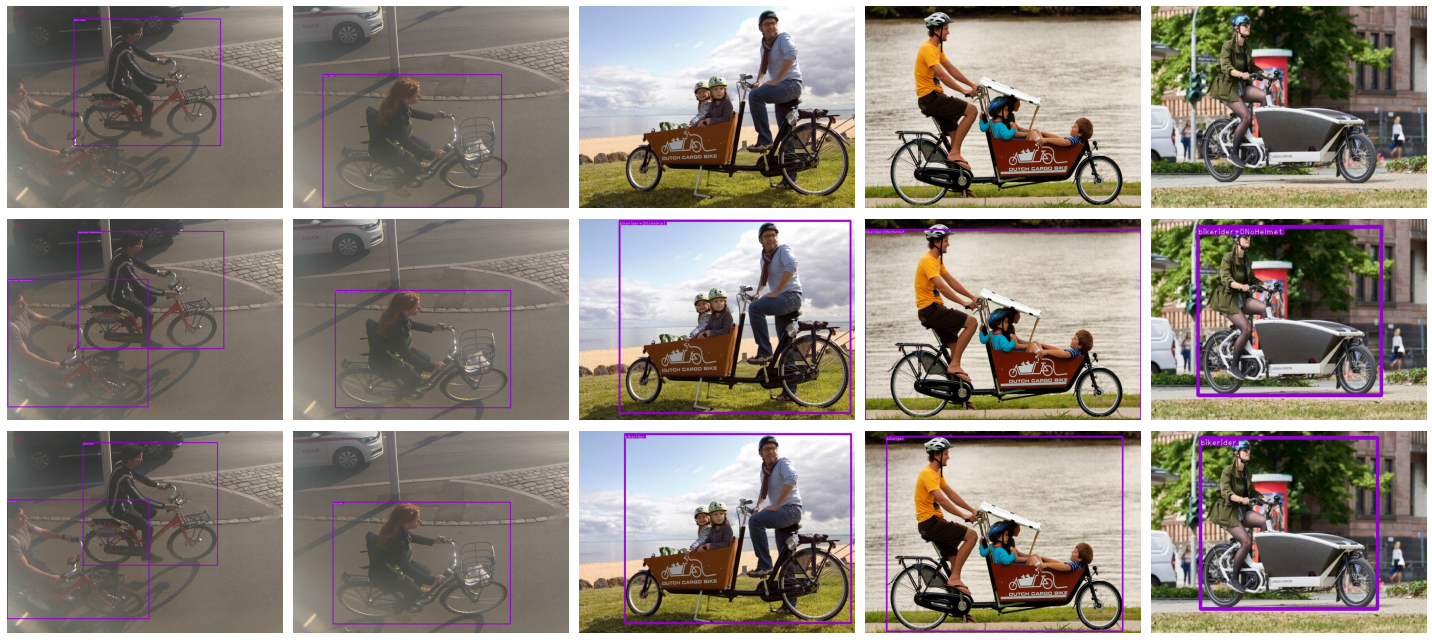

In [44]:
figure = plt.gcf()
figure.set_size_inches(20, 9)
for i, (key, value) in enumerate(all_figs.items()):
    for j in range(5):
        plt.subplot(3, 5, i*5+j+1)
        img = value[j][:, :, ::-1]
        if img.shape[0]/img.shape[1] > 1:
            img = img[1100:, :, :]
        plt.imshow(img, aspect="auto")
        plt.axis('off')
figure.tight_layout()
figure.subplots_adjust()
plt.savefig('detections.jpg', dpi=300)